In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm

import my_funcs as mf

## Upwind vs Fact

In [2]:
# n=101
# L=1
# T=1
# kurant=0.5

# h=L/(n-1)
# tau=kurant*h

# b=(n-1)*0.1 #width % of L

# l=[i/(n-1) for i in range(0,n)]
# v=[1 if i in range(1,int(b)+1) else 0 for i in range(0,n) ]
# print('Доля 1:',np.round(100*v.count(1)/len(v),3))

# plt.plot(l,v,'-*')
# plt.grid()

In [3]:
# final_time=0.2
# fact_v,_=mf.advection_upwind(v,final_time,1,h,n)
# new_v_0_50,_=mf.advection_upwind(v,final_time,0.5,h,n)
# new_v_0_75,_=mf.advection_upwind(v,final_time,0.75,h,n)
# new_v_0_90,_=mf.advection_upwind(v,final_time,0.90,h,n)
# new_v_0_25,_=mf.advection_upwind(v,final_time,0.25,h,n)
# plt.figure(figsize=(10,8))
# plt.plot(l,fact_v,'--',label='Точное решение : kurant = 1',color='black')
# plt.plot(l,new_v_0_90,label=r'Upwind : kurant = 0.9',color='blue')
# plt.plot(l,new_v_0_75,label=r'Upwind : kurant = 0.75',color='orange')
# plt.plot(l,new_v_0_50,label=r'Upwind : kurant = 0.5',color='red')
# plt.plot(l,new_v_0_25,label=r'Upwind : kurant = 0.25',color='cyan')
# plt.legend()
# plt.title(fr'mesh : {n}')

# final_time=0.8
# fact_v,_=mf.advection_upwind(v,final_time,1.0,h,n)
# new_v_0_50,_=mf.advection_upwind(v,final_time,0.5,h,n)
# new_v_0_75,_=mf.advection_upwind(v,final_time,0.75,h,n)
# new_v_0_90,_=mf.advection_upwind(v,final_time,0.90,h,n)
# new_v_0_25,_=mf.advection_upwind(v,final_time,0.25,h,n)
# # plt.figure(figsize=(10,8))
# plt.plot(l,fact_v,'--',label='Точное решение : kurant = 1',color='black')
# plt.plot(l,new_v_0_90,label=r'Upwind : kurant = 0.9',color='blue')
# plt.plot(l,new_v_0_75,label=r'Upwind : kurant = 0.75',color='orange')
# plt.plot(l,new_v_0_50,label=r'Upwind : kurant = 0.5',color='red')
# plt.plot(l,new_v_0_25,label=r'Upwind : kurant = 0.25',color='cyan')
# plt.grid()

## STENCIL-NET

In [4]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from stencilnet import MLPConv, forward_rk3_error, backward_rk3_error,backward_rk3_tvd_error,forward_rk3_tvd_error
from stencilnet import forward_rk1_error,backward_rk1_error
from utils import load_simulation_model

##### 0. Mesh Params

In [5]:
generate_flg=True # True - генерация, False - чтение уже сгенерированных
# generate_flg=False

n=101 #число узлов
L=1 # длина расчт области
T=.8 #конечное время
kurant=1

h=L/(n-1)
b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
v=[1 if i in range(1,int(b)+1) else 0 for i in range(0,n) ]
print('Доля единиц:',np.round(100*v.count(1)/len(v),3))

Доля единиц: 9.901


##### 1. Study params

## NB! Для теста сделал fs=3, neurons=7

In [6]:
#------------------------MAIN PARAMS-----------------------------
# size of filter to be applied
fs = 7#7 #???
# number of timesteps to be predicted during training 
m = 4 #4 #???
# decaying weights
decay_const = 0.9 #???
# epoch_number
epochs=4000
#random_seed
seed = 1 
#coef для loss функции
l_wd= 1e-7 
# 'RK3' for runge-kutta solver and 'E1' for euler solver
method='RK3' 
# method='E1'
#neurons num in MLPConv
neurons=64 #64
#learning_rate
lr=1e-2
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### 2. Generate data

In [7]:
CUSTOM_TAU=0.009
v_fact,x_lst,tau,time_lst=mf.generate_data(generate_flg,v,T,L,1,h,n,CUSTOM_TAU=CUSTOM_TAU,save_flg=False)

Генерация данных


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 566.46it/s]

89 101
101 89


In [8]:
print('h',h,h**2)
print('tau',tau)
assert tau/h<1,'не выполнено ограничение на число Куранта'

h 0.01 0.0001
tau 0.009


Text(0.5, 1.0, 'Фактические данные')

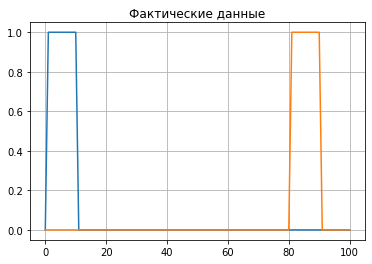

In [9]:
#view
plt.plot(v_fact[:,0])
plt.plot(v_fact[:,-1])
plt.grid()
plt.title('Фактические данные')

##### 3.Subsample Data

In [10]:
t_factor = 10  # time subsample factor 
s_factor = 4   # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=mf.subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=0.7)

full_sample (26, 9)
train (26, 6)
test (26, 3)


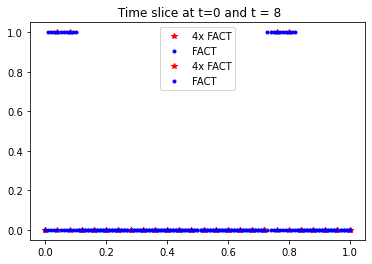

In [11]:
plt.figure()
time=0 #first time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
time=v_coarse.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t=0 and t = " + str(time))
plt.show()

##### 4. Trainig model

In [12]:
v_train = torch.tensor(v_coarse_train.T, requires_grad=True, dtype=torch.float, device=device)

np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# 64, 64,
net       = MLPConv([fs,neurons,neurons, neurons, 1], seed=seed, fs=fs, 
                    activation=nn.ELU()).to(device)
                    # activation=nn.Sigmoid()).to(device)
                    # activation=nn.ReLU()).to(device)
params    = [{'params': net.parameters(), 'lr': lr}]
optimizer = Adam(params)
scheduler = ExponentialLR(optimizer, .9998)

print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))

# decaying weights for accumulating prediction error
output_weights = [decay_const**j for j in range(m+1)] 
wd = torch.tensor(output_weights, dtype=torch.float32, device=device)

loss_lst=[]
pbar = tqdm(range(epochs))
for epoch in pbar:
    optimizer.zero_grad()
    
    # compute forward and backward prediction errors
    if method=='RK3':
        fwd = forward_rk3_error(net, v_train, dtc, m, wd)
        bwd = backward_rk3_error(net, v_train, dtc, m, wd)
        # bwd=torch.zeros(1)[0]
    elif method=='E1':
        #my_add rk1
        fwd = forward_rk1_error(net, v_train, dtc, m, wd)
        bwd = backward_rk1_error(net, v_train, dtc, m, wd)
        # bwd=torch.zeros(1)[0]
    else:
        raise 'method error'
    
    # compute norm of weights
    res_w = 0
    for i in range(len(net.layer)):
        W = net.layer[i].weight
        W = W.view(W.shape[0]*W.shape[1], -1)
        res_w = res_w + (torch.norm(W, p=2, dim=0)**2)
        
    loss =  fwd + bwd + l_wd*res_w
    loss_lst.append([fwd.cpu().data.numpy(),bwd.cpu().data.numpy(),
                     l_wd*res_w.cpu().data.numpy()[0],loss.cpu().data.numpy()[0]])
    
    loss.backward()
    optimizer.step()
    
    if epoch > 15_000:
        scheduler.step()
        
    pbar.set_postfix(loss=round(loss.item(), 7))
    

input 7 output 64
input 64 output 64
input 64 output 64
input 64 output 1
#parameters: 8897


100%|████████████████████████████████████████████████████████████████████| 4000/4000 [07:04<00:00,  9.42it/s, loss=121]


In [13]:
# for j in net.layer:
#     print(fr'-----{j}------')
#     print(j.weight)

In [14]:
# W.view(W.shape[0]*W.shape[1], -1)

In [15]:
# plt.plot(W.cpu().data.numpy()[:,0])

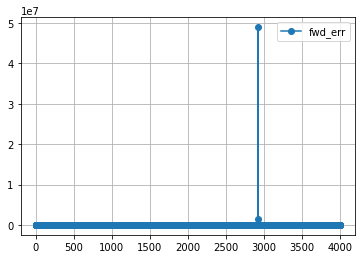

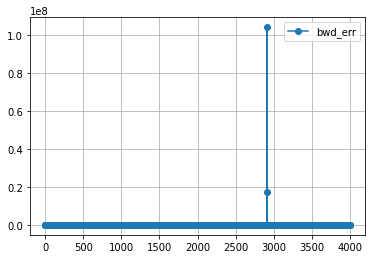

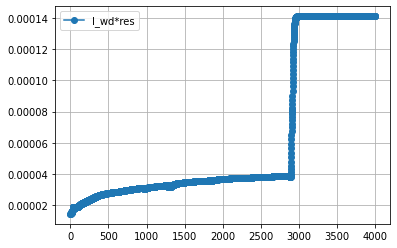

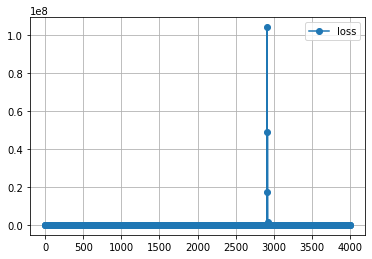

In [16]:
mf.plot_err_and_components_of_err(np.array(loss_lst))

##### 5. save_model

In [17]:
# torch.save(net, './models/model_advection_n=' +str(n)+'_'+ str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

##### 6. load_model

In [18]:
# neurons = 64
# fs=7
# epochs=100
# m=4
# l_wd=0#1e-3
# seed=1
#method='E1'

# net = load_simulation_model(s_factor, t_factor, neurons, device)

# net=torch.load('./models/model_advection_n=' +str(n)+'_' + str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

##### 7. Simulation

In [19]:
# Lx_sim = int(n/s_factor)
Lx_sim=v_coarse.shape[0]
x_sim  = np.linspace(0,L,Lx_sim)
dxs    = x_sim[1] - x_sim[0]
dts    = dtc
T_sim=v_coarse.shape[1]

NN_sim   = np.zeros((Lx_sim,T_sim))
phase_NN=np.zeros((Lx_sim,T_sim))

# NN_sim[:,0] = np.exp(-(x_sim-3)**2)
NN_sim[:,0]=v_coarse[:,0]

zf   = 0
time = 0
for j in tqdm(range(0,T_sim-1)):
    if method=='RK3':
        tensor = NN_sim[:,j].reshape(1,Lxc)
        torch_tensor = torch.tensor(tensor,dtype=torch.float,device=device)

        phase_NN[:,j] = net(torch_tensor).cpu().data.numpy()
        k1   =  dts*phase_NN[:,j] #+ dts*forcing
        temp =  NN_sim[:,j] + 0.5*k1 

        tensor = temp.reshape(1,Lxc)
        torch_tensor = torch.tensor(tensor,dtype=torch.float,device=device)


        k2   =  dts*net(torch_tensor).cpu().data.numpy() #+ dts*forcing
        temp =  NN_sim[:,j] - k1 + 2.0*k2

        tensor = temp.reshape(1,Lxc)
        torch_tensor = torch.tensor(tensor,dtype=torch.float,device=device)

        k3   =  dts*net(torch_tensor).cpu().data.numpy() #+ dts*forcing

        NN_sim[:,j+1] = NN_sim[:,j] + (1./6.)*(k1 + 4.0*k2 + k3)

        time = time + dts
    
    elif method=='E1':
        tensor = NN_sim[:,j].reshape(1,Lxc)
        torch_tensor = torch.tensor(tensor,dtype=torch.float,device=device)

        NN_sim[:,j+1] = NN_sim[:,j]+dts*net(torch_tensor).cpu().data.numpy()

        time = time + dts
        
    else:
        raise 'method error'

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 211.58it/s]


In [20]:
net.sig

ELU(alpha=1.0)

##### 8. view_results

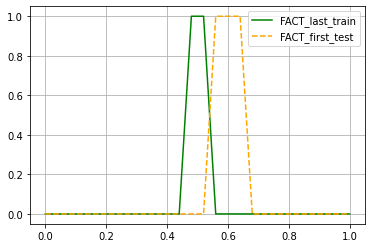

In [21]:
mf.view_train_test_graph(x_sim,v_coarse_train,v_coarse_test)

In [22]:
len([int(i) for i in np.linspace(0,T_sim-1,5)]),T_sim


(5, 9)

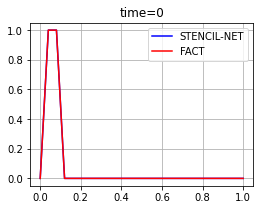

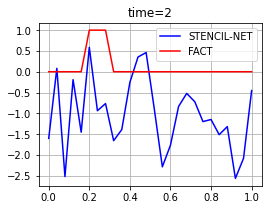

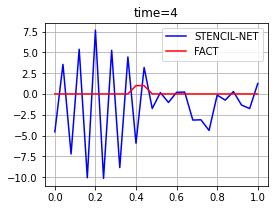

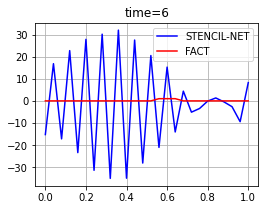

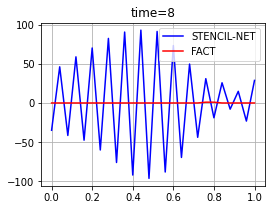

In [23]:
mf.view_results(T_sim,x_sim,NN_sim,v_coarse)